In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

#Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'
Path = '../../data/firstRound_4h.csv'


df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,0.679482,0.674135,0.648157,0.667258,0.016757,0.147150,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA


In [3]:
df['Group'] = 'bsp'
#uni_random_30 = df[60:90]
df.loc[60:90, 'Group'] = 'uni random'
df.loc[90:110, 'Group'] = 'pwm random'
df.loc[110:150, 'Group'] = 'bandit'

In [4]:
df

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA,bsp
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA,bsp
2,2,GTTAAGAAGGAGATATACAT,0.679482,0.674135,0.648157,0.667258,0.016757,0.147150,AGGAGA,bsp
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA,bsp
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA,bsp
5,5,TGTAAGAAGGAGATATACAT,0.202312,0.057379,0.327541,0.195744,0.135201,0.167616,AGGAGA,bsp
6,6,TATAAGAAGGAGATATACAT,1.462416,1.265102,0.647586,1.125035,0.425089,0.188381,AGGAGA,bsp
7,7,TTGAAGAAGGAGATATACAT,1.783312,1.696347,NaN,1.739829,0.061494,0.174465,AGGAGA,bsp
8,8,TTAAAGAAGGAGATATACAT,0.522793,0.525399,0.968039,0.672077,0.256314,0.141920,AGGAGA,bsp
9,9,TTTCAGAAGGAGATATACAT,1.734395,0.862538,0.440900,1.012611,0.659677,0.291482,AGGAGA,bsp


In [5]:
df.sort_values(by = ['Rep3'], ascending = False).head(10)

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA,bsp
60,60,TTTAAGAGTTGACTATACAT,1.202708,1.117007,1.549520,1.289745,0.229016,0.169207,GTTGAC,uni random
48,48,TTTAAGAAGGAGATATCCAT,1.412313,0.832596,1.334433,1.193114,0.314637,0.250112,AGGAGA,bsp
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA,bsp
13,13,TTTAGGAAGGAGATATACAT,1.509236,1.383499,1.172609,1.355114,0.170099,0.177962,AGGAGA,bsp
11,11,TTTTAGAAGGAGATATACAT,2.258204,1.485261,1.154576,1.632680,0.566390,0.264738,AGGAGA,bsp
12,12,TTTACGAAGGAGATATACAT,1.836717,1.425537,1.150502,1.470919,0.345351,0.219306,AGGAGA,bsp
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA,bsp
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA,bsp
8,8,TTAAAGAAGGAGATATACAT,0.522793,0.525399,0.968039,0.672077,0.256314,0.141920,AGGAGA,bsp


## Violinplot with AVERAGE value

In [6]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA,bsp
47,47,TTTAAGAAGGAGATAAACAT,2.656289,1.982298,0.910435,1.849674,0.880450,0.246420,AGGAGA,bsp
10,10,TTTGAGAAGGAGATATACAT,2.164824,2.119042,0.962352,1.748739,0.681416,0.171995,AGGAGA,bsp
7,7,TTGAAGAAGGAGATATACAT,1.783312,1.696347,NaN,1.739829,0.061494,0.174465,AGGAGA,bsp
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA,bsp
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA,bsp
11,11,TTTTAGAAGGAGATATACAT,2.258204,1.485261,1.154576,1.632680,0.566390,0.264738,AGGAGA,bsp
59,59,TTTAAGAAGGAGATATACAA,2.783385,1.964840,0.123219,1.623814,1.362477,0.262133,AGGAGA,bsp
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA,bsp
115,137,TTTAAGAATAAGATATACAT,1.639034,2.442033,0.721234,1.600767,0.861037,0.095234,ATAAGA,bandit


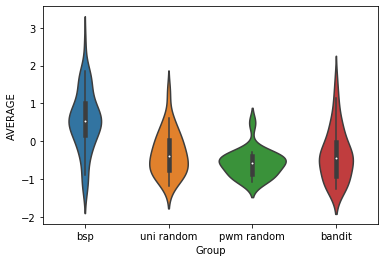

In [7]:
sns.violinplot(x="Group", y="AVERAGE", data=df)

## Violinplot with all replications

In [8]:
df_all_rep = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_all_rep = df_all_rep.dropna()

In [9]:
df_all_rep.sort_values(by = ['value'], ascending = False).head(10)

,RBS,Group,variable,value
0,TTTAAGAAGGAGATATACAT,bsp,Rep1,3.206399
151,TTTAAGAAGGAGATATACAT,bsp,Rep2,2.793969
59,TTTAAGAAGGAGATATACAA,bsp,Rep1,2.783385
47,TTTAAGAAGGAGATAAACAT,bsp,Rep1,2.656289
266,TTTAAGAATAAGATATACAT,bandit,Rep2,2.442033
11,TTTTAGAAGGAGATATACAT,bsp,Rep1,2.258204
155,TCTAAGAAGGAGATATACAT,bsp,Rep2,2.210364
10,TTTGAGAAGGAGATATACAT,bsp,Rep1,2.164824
161,TTTGAGAAGGAGATATACAT,bsp,Rep2,2.119042
3,ATTAAGAAGGAGATATACAT,bsp,Rep1,1.995148


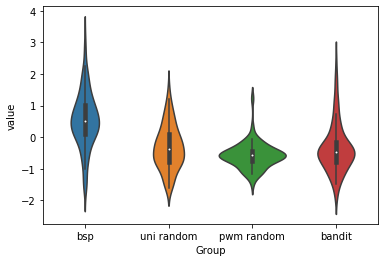

In [10]:
sns.violinplot(x="Group", y="value", data=df_all_rep)

## Predict labels with baseline data as training data

In [11]:
import pickle

with open('trained_reg_model.pickle', 'rb') as handle:
    trained_reg_model_dict = pickle.load(handle)

In [12]:
trained_reg_model_dict

{'all_None_GPR_Spectrum_Kernel_label': GaussianProcessRegressor(alpha=0.5, copy_X_train=True,
                          kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                          n_restarts_optimizer=0, normalize_y=True,
                          optimizer='fmin_l_bfgs_b', random_state=None),
 'First round result_None_GPR_Spectrum_Kernel_label': GaussianProcessRegressor(alpha=0.5, copy_X_train=True,
                          kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                          n_restarts_optimizer=0, normalize_y=True,
                          optimizer='fmin_l_bfgs_b', random_state=None),
 'Baseline data_None_GPR_Spectrum_Kernel_label': GaussianProcessRegressor(alpha=0.5, copy_X_train=True,
                          kernel=Sum_Spectrum_Kernel(sigma_0=1e-10),
                          n_restarts_optimizer=0, normalize_y=True,
                          optimizer='fmin_l_bfgs_b', random_state=None),
 'First round result_Baseline data_GPR_Spectrum_Kernel_label': 

In [13]:
first_round_seq = Rewards_env(np.asarray(df[['RBS', 'AVERAGE']]), 'label').embedded
df['predict mean'], df['predict std']= trained_reg_model_dict['Baseline data_First round result_GPR_Spectrum_Kernel_label'].predict(first_round_seq, return_std=True)
# df['AVERAGE'] = (df['AVERAGE']-df['AVERAGE'].mean())/df['AVERAGE'].std()
df.head()

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group,predict mean,predict std
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA,bsp,-0.049039,0.828803
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA,bsp,0.019010,0.916573
2,2,GTTAAGAAGGAGATATACAT,0.679482,0.674135,0.648157,0.667258,0.016757,0.147150,AGGAGA,bsp,-0.010713,0.915693
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA,bsp,0.071117,0.905331
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA,bsp,0.086639,0.907491


In [14]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,RBS6,Group,predict mean,predict std
0,0,TTTAAGAAGGAGATATACAT,3.206399,2.793969,1.806473,2.602280,0.719379,0.246643,AGGAGA,bsp,-0.049039,0.828803
47,47,TTTAAGAAGGAGATAAACAT,2.656289,1.982298,0.910435,1.849674,0.880450,0.246420,AGGAGA,bsp,-0.049307,0.872673
10,10,TTTGAGAAGGAGATATACAT,2.164824,2.119042,0.962352,1.748739,0.681416,0.171995,AGGAGA,bsp,0.119515,0.914307
7,7,TTGAAGAAGGAGATATACAT,1.783312,1.696347,NaN,1.739829,0.061494,0.174465,AGGAGA,bsp,-0.001412,0.919087
3,3,ATTAAGAAGGAGATATACAT,1.995148,1.956762,1.107399,1.686437,0.501828,0.169798,AGGAGA,bsp,0.071117,0.905331
4,4,TCTAAGAAGGAGATATACAT,1.837960,2.210364,0.989308,1.679211,0.625816,0.117162,AGGAGA,bsp,0.086639,0.907491
11,11,TTTTAGAAGGAGATATACAT,2.258204,1.485261,1.154576,1.632680,0.566390,0.264738,AGGAGA,bsp,0.179403,0.906625
59,59,TTTAAGAAGGAGATATACAA,2.783385,1.964840,0.123219,1.623814,1.362477,0.262133,AGGAGA,bsp,-0.106703,0.895214
1,1,CTTAAGAAGGAGATATACAT,1.852193,1.685123,1.296724,1.611347,0.284989,0.185590,AGGAGA,bsp,0.019010,0.916573
115,137,TTTAAGAATAAGATATACAT,1.639034,2.442033,0.721234,1.600767,0.861037,0.095234,ATAAGA,bandit,-0.235571,0.834916
